all_carriers:   [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
pilot_carriers: [ 0  8 16 24 32 40 48 56 63]
data_carriers:  [ 1  2  3  4  5  6  7  9 10 11 12 13 14 15 17 18 19 20 21 22 23 25 26 27
 28 29 30 31 33 34 35 36 37 38 39 41 42 43 44 45 46 47 49 50 51 52 53 54
 55 57 58 59 60 61 62]


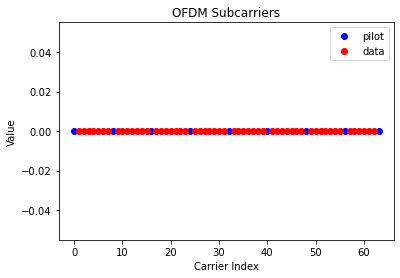

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate

# Constants
K = 64  # Number of OFDM subcarriers
CP = K // 4  # Length of the cyclic prefix: 25% of the block
P = 8  # Number of pilot carriers per OFDM block
pilot_value = 3 + 3j  # The known value each pilot transmits

# Subcarriers
all_carriers = np.arange(K)  # Indices of all subcarriers ([0, 1, ... K-1])

# Pilot carriers are every (K/P)th carrier
pilot_carriers = all_carriers[::K // P]

# Make the last carrier also be a pilot for convenience of channel estimation
pilot_carriers = np.hstack([pilot_carriers, np.array([all_carriers[-1]])])
P += 1  # Update the number of pilot carriers

# Data carriers are all remaining carriers
data_carriers = np.delete(all_carriers, pilot_carriers)

# Display the carriers
print(f"all_carriers:   {all_carriers}")
print(f"pilot_carriers: {pilot_carriers}")
print(f"data_carriers:  {data_carriers}")

# Plot the carriers
plt.plot(pilot_carriers, np.zeros_like(pilot_carriers), 'bo', label='pilot')
plt.plot(data_carriers, np.zeros_like(data_carriers), 'ro', label='data')
plt.xlabel('Carrier Index')
plt.ylabel('Value')
plt.title('OFDM Subcarriers')
plt.legend()
plt.show()


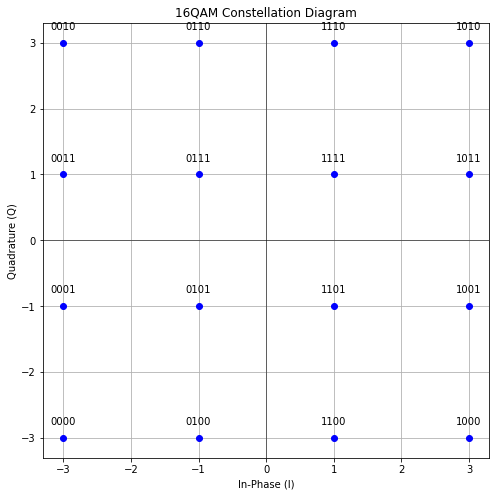

In [19]:

# Constants
mu = 4  # Bits per symbol (i.e., 16QAM)
payload_bits_per_OFDM = len(data_carriers) * mu  # Number of payload bits per OFDM symbol

# 16QAM Mapping Table
mapping_table = {
    (0, 0, 0, 0): -3 - 3j,
    (0, 0, 0, 1): -3 - 1j,
    (0, 0, 1, 0): -3 + 3j,
    (0, 0, 1, 1): -3 + 1j,
    (0, 1, 0, 0): -1 - 3j,
    (0, 1, 0, 1): -1 - 1j,
    (0, 1, 1, 0): -1 + 3j,
    (0, 1, 1, 1): -1 + 1j,
    (1, 0, 0, 0):  3 - 3j,
    (1, 0, 0, 1):  3 - 1j,
    (1, 0, 1, 0):  3 + 3j,
    (1, 0, 1, 1):  3 + 1j,
    (1, 1, 0, 0):  1 - 3j,
    (1, 1, 0, 1):  1 - 1j,
    (1, 1, 1, 0):  1 + 3j,
    (1, 1, 1, 1):  1 + 1j
}

# Plot the 16QAM constellation diagram
plt.figure(figsize=(8, 8))
for b in mapping_table:
    Q = mapping_table[b]
    plt.plot(Q.real, Q.imag, 'bo')
    plt.text(Q.real, Q.imag + 0.2, "".join(map(str, b)), ha='center')

plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.grid(True)
plt.title('16QAM Constellation Diagram')
plt.xlabel('In-Phase (I)')
plt.ylabel('Quadrature (Q)')
plt.show()


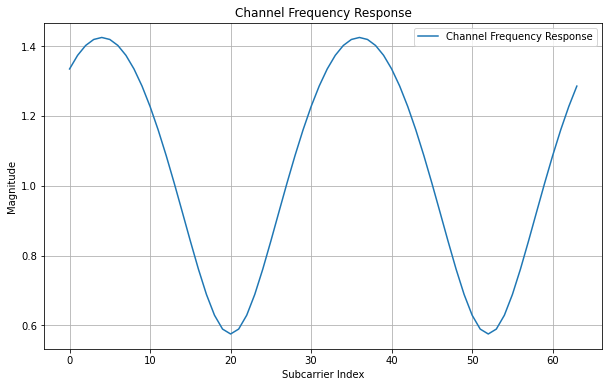

In [20]:
# Demapping table
demapping_table = {v: k for k, v in mapping_table.items()}

# Channel response
channel_response = np.array([1, 0, 0.3 + 0.3j])  # The impulse response of the wireless channel
H_exact = np.fft.fft(channel_response, K)

# Plot the frequency response of the channel
plt.figure(figsize=(10, 6))
plt.plot(all_carriers, abs(H_exact), label='Channel Frequency Response')
plt.title('Channel Frequency Response')
plt.xlabel('Subcarrier Index')
plt.ylabel('Magnitude')
plt.grid(True)
plt.legend()
plt.show()

# Signal-to-noise ratio (SNR) in dB at the receiver
SNR_db = 25

In [21]:
# Generate random bits
bits = np.random.binomial(n=1, p=0.5, size=payload_bits_per_OFDM)

In [22]:
# Serial to parallel conversion
def serial_to_parallel(bits):
    return bits.reshape((len(data_carriers), mu))

# Convert bits to parallel
bits_SP = serial_to_parallel(bits)

In [23]:
# Mapping function
def mapping(bits):
    return np.array([mapping_table[tuple(b)] for b in bits])

# Convert bits to QAM symbols
QAM = mapping(bits_SP)

# Display the first 5 QAM symbols and their corresponding bits
print("First 5 QAM symbols and bits:")
print("Bits:")
print(bits_SP[:5, :])
print("QAM Symbols:")
print(QAM[:5])

First 5 QAM symbols and bits:
Bits:
[[1 0 0 1]
 [1 1 1 1]
 [1 0 1 0]
 [0 1 1 0]
 [0 0 1 0]]
QAM Symbols:
[ 3.-1.j  1.+1.j  3.+3.j -1.+3.j -3.+3.j]


In [24]:
# Function to create an OFDM symbol
def ofdm_symbol(QAM_payload):
    symbol = np.zeros(K, dtype=complex)  # Initialize the overall K subcarriers
    symbol[pilot_carriers] = pilot_value  # Allocate the pilot subcarriers 
    symbol[data_carriers] = QAM_payload  # Allocate the data subcarriers
    return symbol

# Create an OFDM symbol with the QAM payload
OFDM_data = ofdm_symbol(QAM)

# Display the number of OFDM carriers in the frequency domain
print("Number of OFDM carriers in frequency domain: ", len(OFDM_data))


Number of OFDM carriers in frequency domain:  64


In [25]:
# Function to perform Inverse Discrete Fourier Transform (IDFT)
def idft(ofdm_data):
    return np.fft.ifft(ofdm_data)

# Perform IDFT to get time-domain OFDM samples
OFDM_time = idft(OFDM_data)

# Display the number of OFDM samples in the time domain before adding the cyclic prefix
print("Number of OFDM samples in time-domain before CP: ", len(OFDM_time))


Number of OFDM samples in time-domain before CP:  64


In [26]:
def add_cp(OFDM_time):
    cp = OFDM_time[-CP:]               # take the last CP samples ... CP 設定為 k//4 -> 達到 25%
    return np.hstack([cp, OFDM_time])  # ... and add them to the beginning
OFDM_withCP = add_cp(OFDM_time)
print ("Number of OFDM samples in time domain with CP: ", len(OFDM_withCP))

Number of OFDM samples in time domain with CP:  80


RX Signal power: 0.2005. Noise power: 0.0006


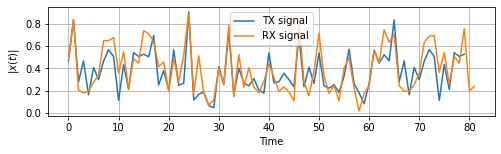

In [27]:
# Function to simulate the channel effect on the transmitted signal
def channel(signal):
    convolved = np.convolve(signal, channel_response)
    signal_power = np.mean(abs(convolved**2))
    sigma2 = signal_power * 10**(-SNR_db/10)  # Calculate noise power based on signal power and SNR
    
    print("RX Signal power: %.4f. Noise power: %.4f" % (signal_power, sigma2))
    
    # Generate complex noise with given variance
    noise = np.sqrt(sigma2/2) * (np.random.randn(*convolved.shape) + 1j*np.random.randn(*convolved.shape))
    return convolved + noise

# Assume OFDM_withCP is already defined somewhere in your code
OFDM_TX = OFDM_withCP  # Uncomment this line if OFDM_withCP is defined
# Simulate the channel effect on the transmitted OFDM signal
OFDM_RX = channel(OFDM_TX)

# Plot the transmitted and received signals
plt.figure(figsize=(8, 2))
plt.plot(abs(OFDM_TX), label='TX signal')
plt.plot(abs(OFDM_RX), label='RX signal')
plt.legend(fontsize=10)
plt.xlabel('Time')
plt.ylabel('$|x(t)|$')
plt.grid(True)
plt.show()


In [28]:
# Function to remove the Cyclic Prefix (CP) from the received signal
def remove_cp(signal):
    return signal[CP:(CP + K)]

# Remove the CP from the received OFDM signal
OFDM_RX_noCP = remove_cp(OFDM_RX)

# Display a portion of the signal for verification
print("First 5 samples of the received OFDM signal without CP:")
print(OFDM_RX_noCP[:5])

First 5 samples of the received OFDM signal without CP:
[ 0.34426312+0.62375653j -0.61332702+0.18815753j  0.03523275+0.41376886j
 -0.45560856+0.04132174j  0.1653547 +0.10889697j]


In [29]:
def DFT(OFDM_RX):
    return np.fft.fft(OFDM_RX)
OFDM_demod = DFT(OFDM_RX_noCP)

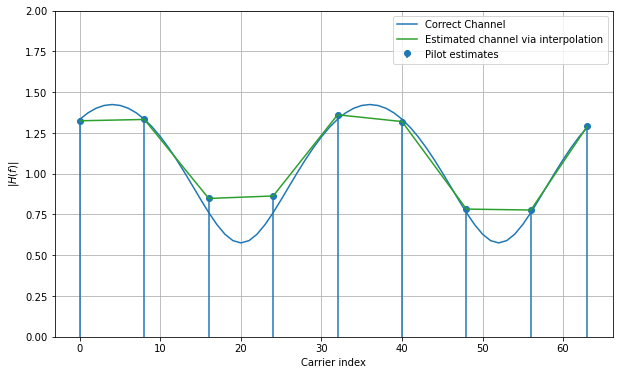

In [30]:
# Function to estimate the channel
def channel_estimate(ofdm_demod):
    pilots = ofdm_demod[pilot_carriers]  # Extract the pilot values from the RX signal
    Hest_at_pilots = pilots / pilot_value  # Divide by the transmitted pilot values
    
    # Perform interpolation between the pilot carriers to get an estimate
    # of the channel in the data carriers. Here, we interpolate absolute value and phase separately
    Hest_abs = scipy.interpolate.interp1d(pilot_carriers, abs(Hest_at_pilots), kind='linear')(all_carriers)
    Hest_phase = scipy.interpolate.interp1d(pilot_carriers, np.angle(Hest_at_pilots), kind='linear')(all_carriers)
    Hest = Hest_abs * np.exp(1j * Hest_phase)
    
    # Plot the correct and estimated channel responses
    plt.figure(figsize=(10, 6))
    plt.plot(all_carriers, abs(H_exact), label='Correct Channel')
    plt.stem(pilot_carriers, abs(Hest_at_pilots), label='Pilot estimates', basefmt=" ", use_line_collection=True)
    plt.plot(all_carriers, abs(Hest), label='Estimated channel via interpolation')
    plt.grid(True)
    plt.xlabel('Carrier index')
    plt.ylabel('$|H(f)|$')
    plt.legend(fontsize=10)
    plt.ylim(0, 2)
    plt.show()
    
    return Hest

Hest = channel_estimate(OFDM_demod)


In [31]:
# Function to equalize the received OFDM symbol using the estimated channel
def equalize(ofdm_demod, hest):
    return ofdm_demod / hest

# Perform channel equalization
equalized_Hest = equalize(OFDM_demod, Hest)

# Display a portion of the equalized signal for verification
print("First 5 samples of the equalized signal:")
print(equalized_Hest[:5])

First 5 samples of the equalized signal:
[ 3.        +3.j          3.22701282-0.89120001j  0.90139013+1.01259253j
  3.12785261+3.35630981j -1.27010299+3.26652435j]


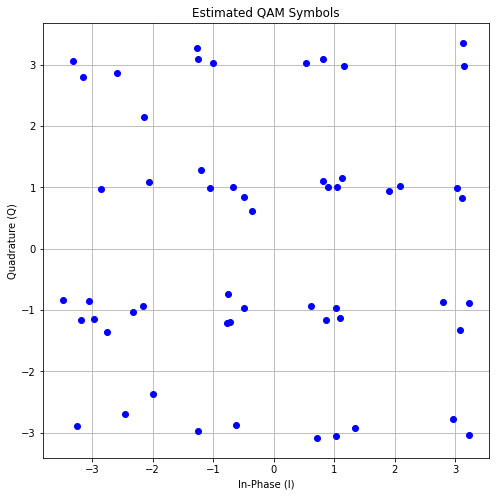

In [32]:
# Function to extract the payload from the equalized OFDM symbol
def get_payload(equalized):
    return equalized[data_carriers]

# Extract the payload (QAM symbols) from the equalized signal
QAM_est = get_payload(equalized_Hest)

# Plot the estimated QAM symbols
plt.figure(figsize=(8, 8))
plt.plot(QAM_est.real, QAM_est.imag, 'bo')
plt.title('Estimated QAM Symbols')
plt.xlabel('In-Phase (I)')
plt.ylabel('Quadrature (Q)')
plt.grid(True)
plt.show()


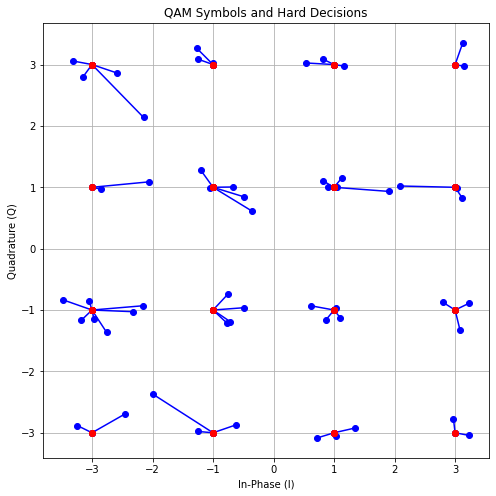

In [33]:
# Function to demap the received QAM symbols to bits
def demapping(QAM):
    # Array of possible constellation points
    constellation = np.array([x for x in demapping_table.keys()])
    
    # Calculate distance of each RX point to each possible point
    dists = abs(QAM.reshape((-1, 1)) - constellation.reshape((1, -1)))
    
    # For each element in QAM, choose the index in constellation 
    # that belongs to the nearest constellation point
    const_index = dists.argmin(axis=1)
    
    # Get back the real constellation point
    hard_decision = constellation[const_index]
    
    # Transform the constellation point into the bit groups
    return np.vstack([demapping_table[C] for C in hard_decision]), hard_decision

# Demap the estimated QAM symbols to bits
PS_est, hard_decision = demapping(QAM_est)

# Plot the QAM symbols and their nearest constellation points
plt.figure(figsize=(8, 8))
for qam, hard in zip(QAM_est, hard_decision):
    plt.plot([qam.real, hard.real], [qam.imag, hard.imag], 'b-o')
plt.plot(hard_decision.real, hard_decision.imag, 'ro')
plt.title('QAM Symbols and Hard Decisions')
plt.xlabel('In-Phase (I)')
plt.ylabel('Quadrature (Q)')
plt.grid(True)
plt.show()


In [34]:
# Function to convert parallel bits back to serial
def parallel_to_serial(bits):
    return bits.reshape((-1,))

# Convert the estimated bits from parallel to serial
bits_est = parallel_to_serial(PS_est)

# Calculate and display the bit error rate (BER)
bit_error_rate = np.sum(abs(bits - bits_est)) / len(bits)
print("Obtained Bit Error Rate: ", bit_error_rate)


Obtained Bit Error Rate:  0.00909090909090909
